### Task 2 (kernels: https://github.com/ysig/GraKeL)

In [54]:
import networkx as nx
import numpy as np
from grakel import graph_from_networkx

loaded = np.load('/mnt/c/Users/danie/PycharmProjects/ml-2024/hw3/t2_data/easy_small.npz', allow_pickle=True)

A_train = list(loaded['tr_adj'])  # list of adjacency matrices
X_train = loaded['tr_feat']  # node features
y_train = loaded['tr_class']  # class labels
A_test = list(loaded['te_adj'])  # list of adjacency matrices
X_test = loaded['te_feat']  # node features
y_test = loaded['te_class']  # class labels

# Convert to networkx format
G_tr = []
for a, x in zip(A_train, X_train):
    G = nx.from_scipy_sparse_matrix(a)
    x_tuple = tuple(map(tuple, x))
    nx.set_node_attributes(G, dict(enumerate(x_tuple)), 'features')
    G_tr.append(G)
G_te = []
for a, x in zip(A_test, X_test):
    G = nx.from_scipy_sparse_matrix(a)
    x_tuple = tuple(map(tuple, x))
    nx.set_node_attributes(G, dict(enumerate(x_tuple)), 'features')
    G_te.append(G)

# Convert to GraKel format
G_train = graph_from_networkx(G_tr, node_labels_tag='features')
G_train = [g for g in G_train]
y_train = np.argmax(y_train, axis=-1)
G_test = graph_from_networkx(G_te, node_labels_tag='features')
G_test = [g for g in G_test]
y_test = np.argmax(y_test, axis=-1)

/tmp/ipykernel_1269/387088416.py:17: DeprecationWarning: 

The scipy.sparse array containers will be used instead of matrices
in Networkx 3.0. Use `from_scipy_sparse_array` instead.
  G = nx.from_scipy_sparse_matrix(a)
/tmp/ipykernel_1269/387088416.py:23: DeprecationWarning: 

The scipy.sparse array containers will be used instead of matrices
in Networkx 3.0. Use `from_scipy_sparse_array` instead.
  G = nx.from_scipy_sparse_matrix(a)


In [55]:
from grakel.kernels import WeisfeilerLehman, ShortestPath, VertexHistogram

kernels = {
    'Weisfeiler-Lehman': WeisfeilerLehman(n_iter=5, normalize=True),
    'Shortest Path': ShortestPath(normalize=True),
    'Vertex Histogram': VertexHistogram(normalize=True)
}

In [4]:
kernel_matrices = {}
for name, kernel in kernels.iteUMAPms():
    kernel.fit(G_train)
    kernel_matrices[name] = kernel.transform(G_train)

In [5]:
def compute_distance_matrix(K, metric="sqrt"):
    n = K.shape[0]
    D = np.zeros((n, n))

    for i in range(n):
        for j in range(n):
            if metric == "sqrt":
                D[i, j] = np.sqrt(K[i, i] + K[j, j] - 2 * K[i, j])
            elif metric == "acos":
                D[i, j] = np.arccos(K[i, j] / np.sqrt(K[i, i] * K[j, j]))
            elif metric == "lin":
                D[i, j] = 1 - K[i, j]

    return D

In [6]:
from sklearn.manifold import MDS, TSNE
import matplotlib.pyplot as plt
import umap.umap_ as umap

def show(metric):
    distance_matrices = {
        name: compute_distance_matrix(K, metric) for name, K in kernel_matrices.items()
    }

    embeddings = {
        "MDS": {},
        "t-SNE": {},
        "UMAP": {}
    }

    for name, D in distance_matrices.items():
        # MDS embedding
        mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42)
        embeddings["MDS"][name] = mds.fit_transform(D)

        # t-SNE embedding
        tsne = TSNE(n_components=2, metric="precomputed", init='random', random_state=42)
        embeddings["t-SNE"][name] = tsne.fit_transform(D)

        # UMAP embedding
        umap_embed = umap.UMAP(n_components=2, metric="precomputed", random_state=42)
        embeddings["UMAP"][name] = umap_embed.fit_transform(D)

    fig, axes = plt.subplots(len(kernels), len(embeddings), figsize=(18, 12))

    for i, (name, D) in enumerate(distance_matrices.items()):
        for j, (method, embed_dict) in enumerate(embeddings.items()):
            axes[i, j].scatter(embed_dict[name][:, 0], embed_dict[name][:, 1], c=y_train, cmap="jet", alpha=0.7)
            axes[i, j].set_title(f"{method} embedding ({name})")

    plt.tight_layout()
    plt.show()

/mnt/c/Users/danie/Documents/Programming/DL_HSE/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/mnt/c/Users/danie/Documents/Programming/DL_HSE/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/mnt/c/Users/danie/Documents/Programming/DL_HSE/.venv/lib/python3.12/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/mnt/c/Users/danie/Documents/Programming/DL_HSE/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/mnt/c/Users/danie/Documents/Programming/DL_HSE/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/mnt/c/Users/danie/Documents/Programming/DL_HSE/.venv/lib/pyt

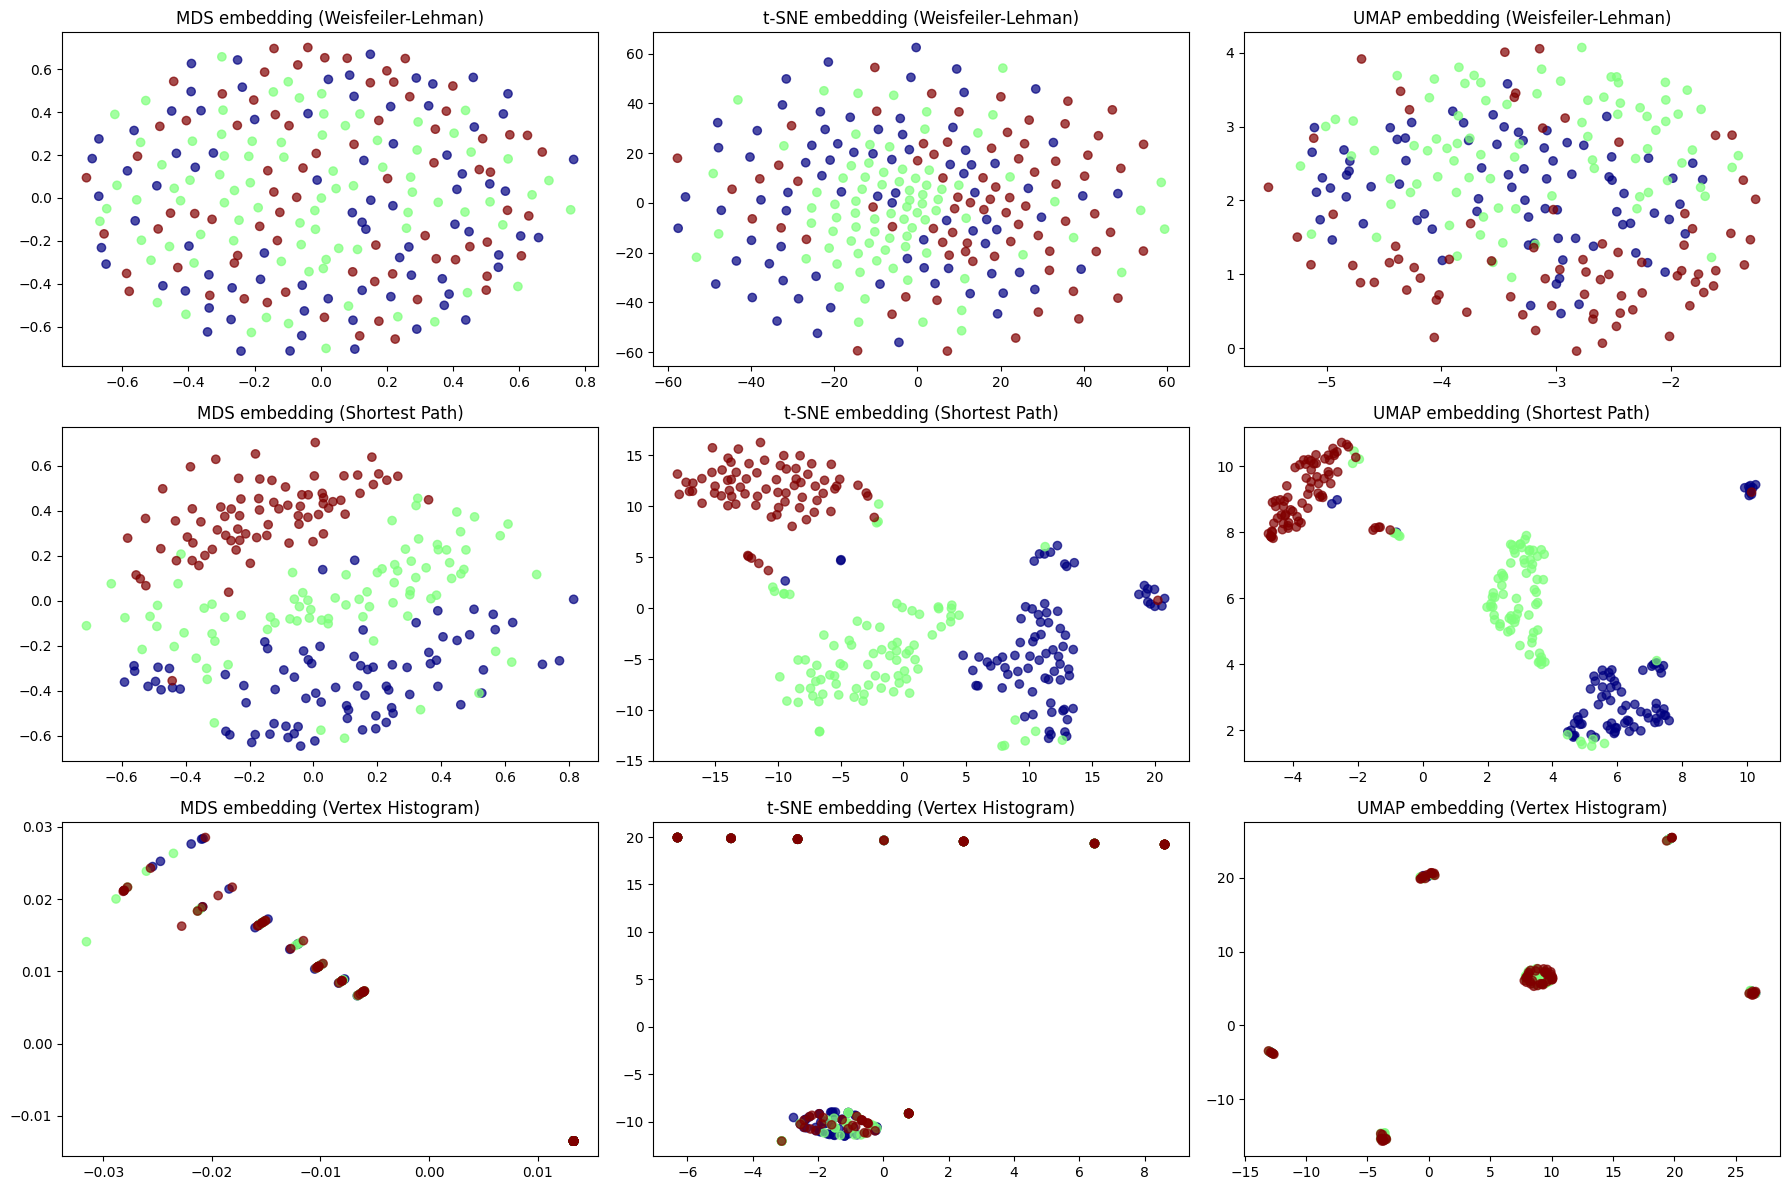

In [7]:
show('sqrt')

/mnt/c/Users/danie/Documents/Programming/DL_HSE/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/mnt/c/Users/danie/Documents/Programming/DL_HSE/.venv/lib/python3.12/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/mnt/c/Users/danie/Documents/Programming/DL_HSE/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/mnt/c/Users/danie/Documents/Programming/DL_HSE/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/mnt/c/Users/danie/Documents/Programming/DL_HSE/.venv/lib/pyt

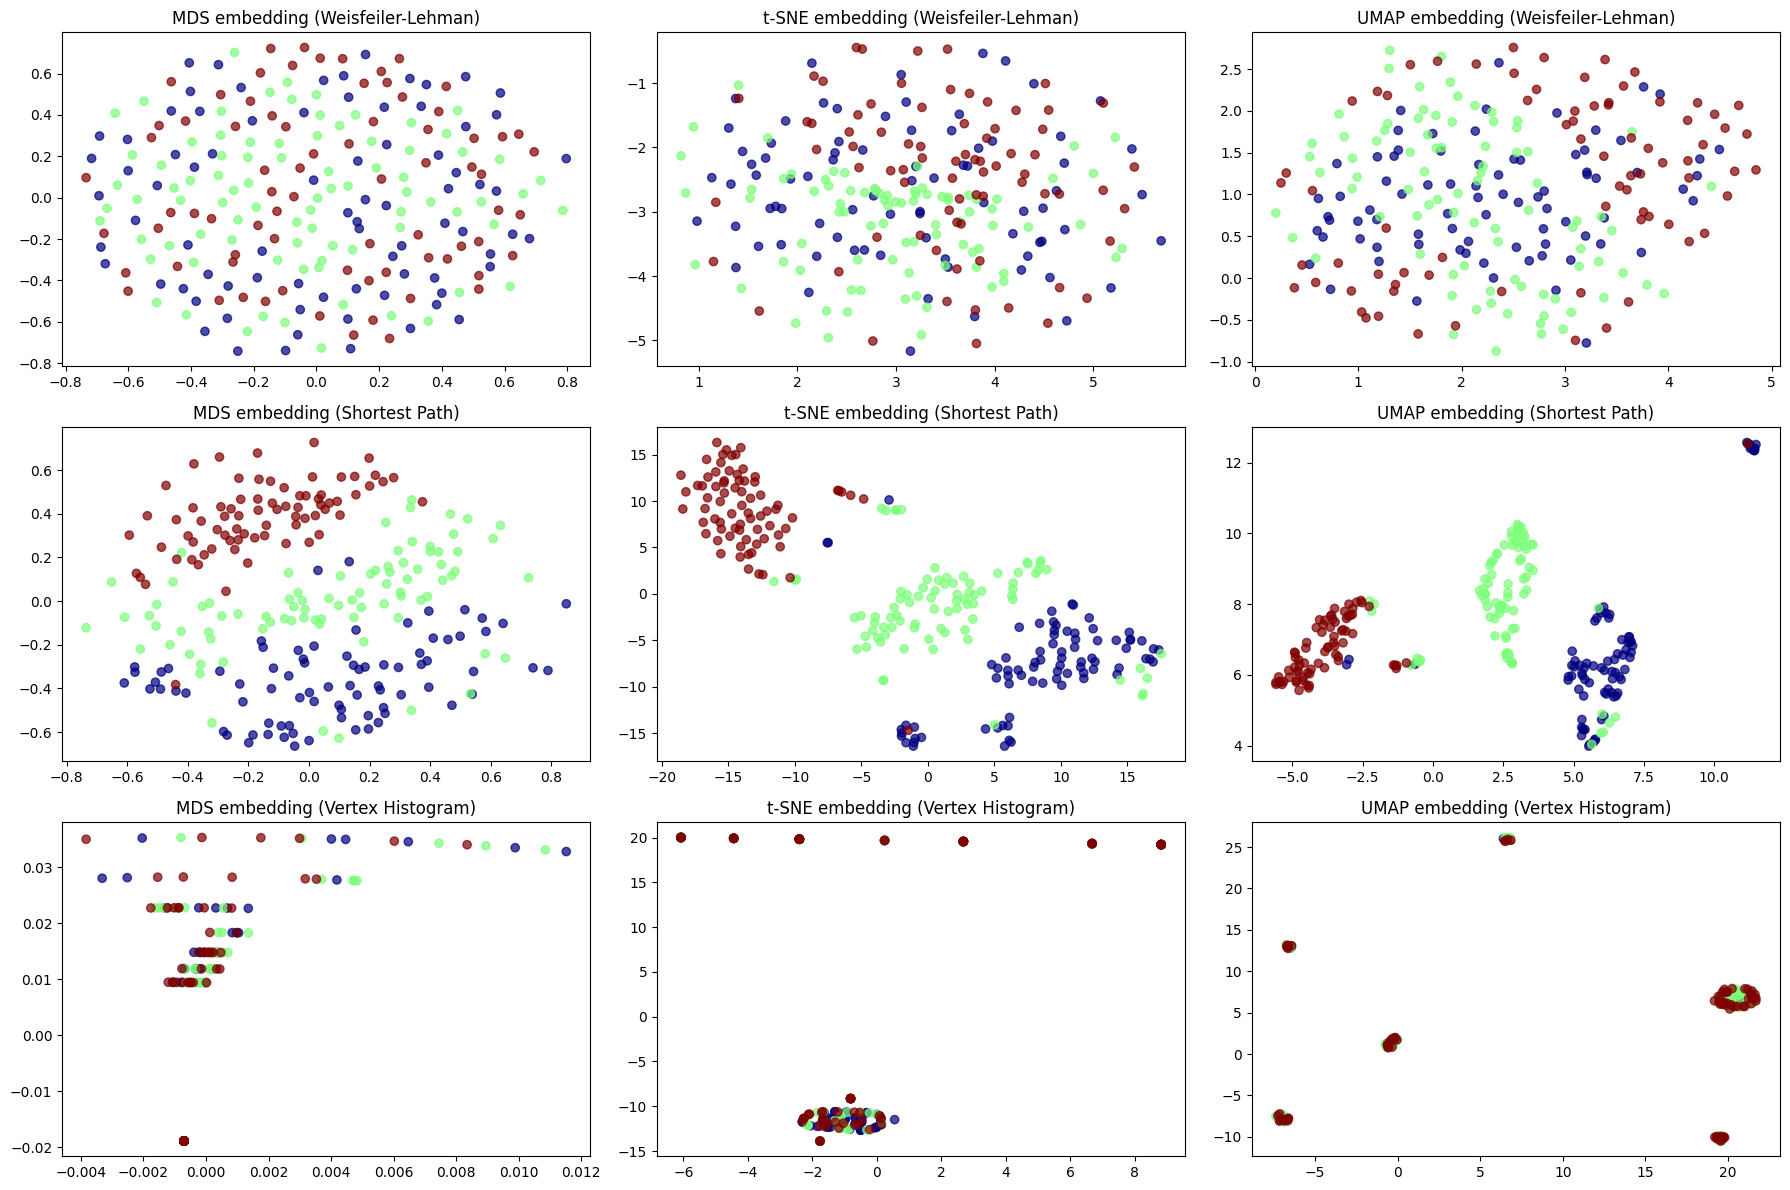

In [8]:
show('acos')

/mnt/c/Users/danie/Documents/Programming/DL_HSE/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/mnt/c/Users/danie/Documents/Programming/DL_HSE/.venv/lib/python3.12/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/mnt/c/Users/danie/Documents/Programming/DL_HSE/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/mnt/c/Users/danie/Documents/Programming/DL_HSE/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/mnt/c/Users/danie/Documents/Programming/DL_HSE/.venv/lib/pyt

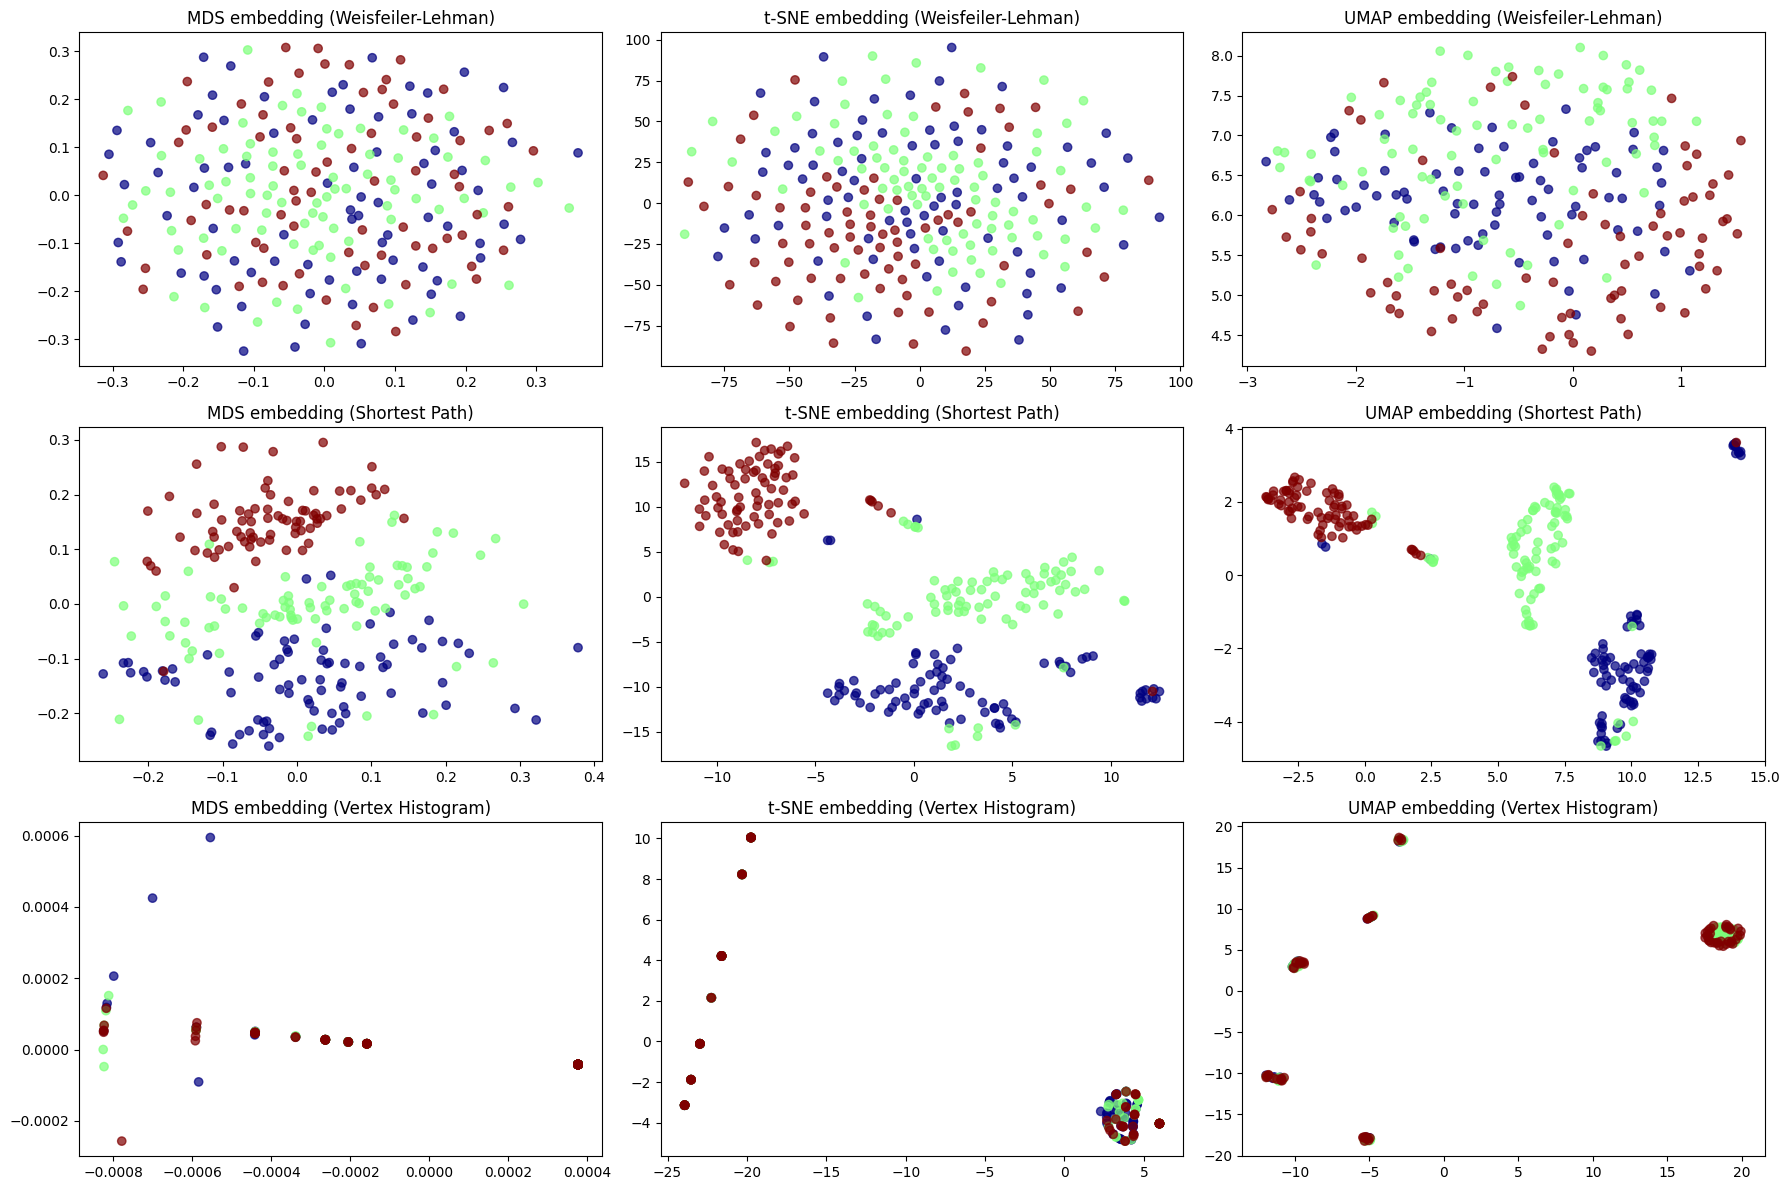

In [9]:
show('lin')

In [11]:
kernel_matrices['Shortest Path']

array([[1.        , 0.72984312, 0.82132666, ..., 0.59704106, 0.65851169,
        0.64911911],
       [0.72984312, 1.        , 0.78504962, ..., 0.61064424, 0.75984949,
        0.68803146],
       [0.82132666, 0.78504962, 1.        , ..., 0.72132276, 0.7341527 ,
        0.81941836],
       ...,
       [0.59704106, 0.61064424, 0.72132276, ..., 1.        , 0.67739999,
        0.89840395],
       [0.65851169, 0.75984949, 0.7341527 , ..., 0.67739999, 1.        ,
        0.74674029],
       [0.64911911, 0.68803146, 0.81941836, ..., 0.89840395, 0.74674029,
        1.        ]])

In [29]:
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

def train_eval():
    # Compute distance matrix using shortest path metric
    distance_matrix = compute_distance_matrix(kernel_matrices["Shortest Path"], "shortest_path")

    embeddings = {}

    # t-SNE embedding
    tsne = TSNE(n_components=2, metric="precomputed", init='random', random_state=42)
    embeddings["t-SNE"] = tsne.fit_transform(distance_matrix)

    # UMAP embedding
    umap_embed = umap.UMAP(n_components=10, metric="precomputed", random_state=42)
    embeddings["UMAP"] = umap_embed.fit_transform(distance_matrix)

    results = {}

    for method, X in embeddings.items():
        # Splitting dataset
        X_train, X_test, y_train_, y_test_ = train_test_split(X, y_train, test_size=0.2, random_state=42)

        # Define models
        models = {
            "XGBClassifier": XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1),
            "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
            "SVM": SVC(kernel='rbf', random_state=42)
        }

        method_results = {}

        for model_name, model in models.items():
            model.fit(X_train, y_train_)
            y_pred = model.predict(X_test)
            acc = accuracy_score(y_test_, y_pred)
            method_results[model_name] = acc
            print(f"Accuracy of {model_name} with {method}: {acc:.4f}")

        results[method] = method_results

    return results

In [30]:
classification_results = train_eval()

/mnt/c/Users/danie/Documents/Programming/DL_HSE/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/mnt/c/Users/danie/Documents/Programming/DL_HSE/.venv/lib/python3.12/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/mnt/c/Users/danie/Documents/Programming/DL_HSE/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Accuracy of XGBClassifier with t-SNE: 0.6458
Accuracy of Random Forest with t-SNE: 0.5833
Accuracy of SVM with t-SNE: 0.6042
Accuracy of XGBClassifier with UMAP: 0.7917
Accuracy of Random Forest with UMAP: 0.8333
Accuracy of SVM with UMAP: 0.8125


Итого, возьмём RandomForst и UMAP и потюним

In [46]:
from sklearn.model_selection import GridSearchCV

def tune_rf_umap():
    umap_params = {'n_components': [2, 5, 10, 20]}

    rf_params = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10]
    }

    best_score = 0
    best_params = None

    for n_components in umap_params['n_components']:
        distance_matrix = compute_distance_matrix(kernel_matrices["Shortest Path"])

        umap_embed = umap.UMAP(n_components=n_components, metric="precomputed", random_state=42)
        X_embedded = umap_embed.fit_transform(distance_matrix)

        X_train, X_test, y_train_, y_test_ = train_test_split(X_embedded, y_train, test_size=0.2, random_state=42)

        rf = RandomForestClassifier(random_state=42)

        grid_search = GridSearchCV(rf, rf_params, cv=5, scoring='accuracy', n_jobs=-1)
        grid_search.fit(X_train, y_train_)

        best_rf = grid_search.best_estimator_

        y_pred = best_rf.predict(X_test)
        acc = accuracy_score(y_test_, y_pred)

        print(f"UMAP n_components={n_components} → Best RF Accuracy: {acc:.4f} with params: {grid_search.best_params_}")

        if acc > best_score:
            best_score = acc
            best_params = {"n_components": n_components, **grid_search.best_params_}

    print("\nBest overall model configuration:")
    print(best_params)
    print(f"Best accuracy achieved: {best_score:.4f}")

    return best_params, best_score

In [47]:
best_params, best_score = tune_rf_umap()

/mnt/c/Users/danie/Documents/Programming/DL_HSE/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/mnt/c/Users/danie/Documents/Programming/DL_HSE/.venv/lib/python3.12/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/mnt/c/Users/danie/Documents/Programming/DL_HSE/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP n_components=2 → Best RF Accuracy: 0.9375 with params: {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 50}


/mnt/c/Users/danie/Documents/Programming/DL_HSE/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/mnt/c/Users/danie/Documents/Programming/DL_HSE/.venv/lib/python3.12/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/mnt/c/Users/danie/Documents/Programming/DL_HSE/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP n_components=5 → Best RF Accuracy: 0.9375 with params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}


/mnt/c/Users/danie/Documents/Programming/DL_HSE/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/mnt/c/Users/danie/Documents/Programming/DL_HSE/.venv/lib/python3.12/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/mnt/c/Users/danie/Documents/Programming/DL_HSE/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP n_components=10 → Best RF Accuracy: 0.9167 with params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}


/mnt/c/Users/danie/Documents/Programming/DL_HSE/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/mnt/c/Users/danie/Documents/Programming/DL_HSE/.venv/lib/python3.12/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/mnt/c/Users/danie/Documents/Programming/DL_HSE/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP n_components=20 → Best RF Accuracy: 0.9375 with params: {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 200}

Best overall model configuration:
{'n_components': 2, 'max_depth': None, 'min_samples_split': 10, 'n_estimators': 50}
Best accuracy achieved: 0.9375


RandomForest + UMAP + sqrt метрика расстояния

In [50]:
def classify_final(set_type='easy'):
    loaded = np.load(f'/mnt/c/Users/danie/PycharmProjects/ml-2024/hw3/t2_data/{set_type}.npz', allow_pickle=True)

    A_train = list(loaded['tr_adj'])  # list of adjacency matrices
    X_train = loaded['tr_feat']  # node features
    y_train = loaded['tr_class']  # class labels
    A_test = list(loaded['te_adj'])  # list of adjacency matrices
    X_test = loaded['te_feat']  # node features
    y_test = loaded['te_class']  # class labels

    # Convert to networkx format
    G_tr = []
    for a, x in zip(A_train, X_train):
        G = nx.from_scipy_sparse_matrix(a)
        x_tuple = tuple(map(tuple, x))
        nx.set_node_attributes(G, dict(enumerate(x_tuple)), 'features')
        G_tr.append(G)
    G_te = []
    for a, x in zip(A_test, X_test):
        G = nx.from_scipy_sparse_matrix(a)
        x_tuple = tuple(map(tuple, x))
        nx.set_node_attributes(G, dict(enumerate(x_tuple)), 'features')
        G_te.append(G)

    # Convert to GraKel format
    G_train = graph_from_networkx(G_tr, node_labels_tag='features')
    G_train = [g for g in G_train]
    y_train = np.argmax(y_train, axis=-1)

    kernel = ShortestPath(normalize=True)

    print('grakel kernel fit_transform')
    kernel_matrix = kernel.fit_transform(G_train)

    print('distance metric')
    distance_matrix = compute_distance_matrix(kernel_matrix)

    print('umap')
    umap_embed = umap.UMAP(n_components=2, metric="precomputed", random_state=42)
    X_embedded = umap_embed.fit_transform(distance_matrix)

    print('splitting')
    X_train_, X_test_, y_train_, y_test_ = train_test_split(X_embedded, y_train, test_size=0.2, random_state=42)

    # {'n_components': 2, 'max_depth': None, 'min_samples_split': 10, 'n_estimators': 50}
    rf = RandomForestClassifier(random_state=42, max_depth=None, n_estimators=50, n_jobs=-1, min_samples_split=10)

    print('rf fitting')
    rf.fit(X_train_, y_train_)
    y_pred = rf.predict(X_test_)

    print(accuracy_score(y_test_, y_pred))

In [51]:
classify_final('easy')

/tmp/ipykernel_1269/581753461.py:14: DeprecationWarning: 

The scipy.sparse array containers will be used instead of matrices
in Networkx 3.0. Use `from_scipy_sparse_array` instead.
  G = nx.from_scipy_sparse_matrix(a)
/tmp/ipykernel_1269/581753461.py:20: DeprecationWarning: 

The scipy.sparse array containers will be used instead of matrices
in Networkx 3.0. Use `from_scipy_sparse_array` instead.
  G = nx.from_scipy_sparse_matrix(a)


grakel kernel fit_transform
distance metric
umap


/mnt/c/Users/danie/Documents/Programming/DL_HSE/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/mnt/c/Users/danie/Documents/Programming/DL_HSE/.venv/lib/python3.12/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/mnt/c/Users/danie/Documents/Programming/DL_HSE/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


splitting
rf fitting
0.9525423728813559


In [52]:
classify_final('hard')

/tmp/ipykernel_1269/581753461.py:14: DeprecationWarning: 

The scipy.sparse array containers will be used instead of matrices
in Networkx 3.0. Use `from_scipy_sparse_array` instead.
  G = nx.from_scipy_sparse_matrix(a)
/tmp/ipykernel_1269/581753461.py:20: DeprecationWarning: 

The scipy.sparse array containers will be used instead of matrices
in Networkx 3.0. Use `from_scipy_sparse_array` instead.
  G = nx.from_scipy_sparse_matrix(a)


grakel kernel fit_transform
distance metric
umap


/mnt/c/Users/danie/Documents/Programming/DL_HSE/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/mnt/c/Users/danie/Documents/Programming/DL_HSE/.venv/lib/python3.12/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/mnt/c/Users/danie/Documents/Programming/DL_HSE/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


splitting
rf fitting
0.5601374570446735


In [53]:
classify_final('hard_small')

/tmp/ipykernel_1269/581753461.py:14: DeprecationWarning: 

The scipy.sparse array containers will be used instead of matrices
in Networkx 3.0. Use `from_scipy_sparse_array` instead.
  G = nx.from_scipy_sparse_matrix(a)
/tmp/ipykernel_1269/581753461.py:20: DeprecationWarning: 

The scipy.sparse array containers will be used instead of matrices
in Networkx 3.0. Use `from_scipy_sparse_array` instead.
  G = nx.from_scipy_sparse_matrix(a)


grakel kernel fit_transform
distance metric
umap
splitting
rf fitting


/mnt/c/Users/danie/Documents/Programming/DL_HSE/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/mnt/c/Users/danie/Documents/Programming/DL_HSE/.venv/lib/python3.12/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/mnt/c/Users/danie/Documents/Programming/DL_HSE/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


0.46938775510204084
